# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/home/ec2-user/data/toxiccomments_train.csv', my_random_seed=74)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 6270, 'TN': 59356, 'FP': 55293, 'FN': 6737, 'Accuracy': 0.5140847277057091, 'Precision': 0.10184688855318942, 'Recall': 0.482048127931114, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12872, 'TN': 114566, 'FP': 83, 'FN': 135, 'Accuracy': 0.9982922855173278, 'Precision': 0.9935932072558857, 'Recall': 0.9896209733220573, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12948, 'TN': 114585, 'FP': 64, 'FN': 59, 'Accuracy': 0.9990364730212445, 'Precision': 0.9950814632646787, 'Recall': 0.9954639809333435, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12749, 'TN': 103299, 'FP': 11350, 'FN': 258, 'Accuracy': 0.9090681205740427, 'Precision': 0.5290261006680775, 'Recall': 0.9801645267932652, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12937, 'TN': 114549, 'FP': 100, 'FN': 70, 'Accuracy': 0.9986682960456226, 'Precision': 0.9923295236634195, 'Recall': 0.994618282463289, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 10944, 'TN': 114470, 'FP': 179, 'FN': 2063, 'Accuracy': 0.9824371749075641, 'Precision': 0.9839072192753754, 'Recall': 0.8413930960252172, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13007, 'Neg': 114649, 'TP': 0, 'TN': 114649, 'FP': 0, 'FN': 13007, 'Accuracy': 0.8981089803847842, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/home/ec2-user/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

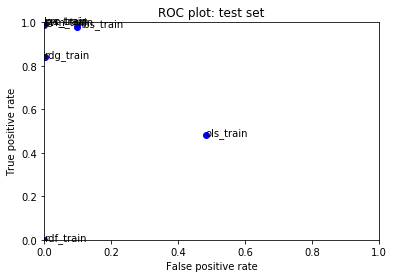

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
96
" Also, I took out the comment about the Bin Laden family, based on Kommissar article, that since the bank was supposedly ""dispersing funds to Osama Bin Laden"", this somehow implicates his family. Since this has never been proven publicly, why is there a presumption that the shareholders would have known? Makes no sense."
* * * * * * * * * 
125
"

Here are some sources that call PETA ""extremist"": Fox News (and again), the [
http://www.findarticles.com/p/articles/mi_m1282/is_24_55/ai_n13606711 National Review], a Welsh local paper, and the Competitive Enterprise Institute.  Those are just the mainstream media outlets and one organization with the same claim to fame as PETA.  Of course, we can add www.petakillsanimals.com and www.peta-sucks.com, but that might cause an argument -)  "
* * * * * * * * * 
164
I am sorry 

I didn't tried to harass Nick Graves. I said nothing wrong about Nick Graves or his wife. I just pointed where he lives. I didn't tried

848
"

I've replaced the reference to ""century old or more"" Kansas City neighborhoods with a more specific dating reference about Stalinism in Russia ""for three generations"", which, barring any warping of human reproductive cycles undisclosed in the novel or alternative history theories, pretty much fixes the date as 2107. —  (talk) 4 July 2005 03:11 (UTC)"
* * * * * * * * * 
859
Made my response on Talk:Peter Siebold to keep the discussion in one place.
* * * * * * * * * 
863
Cirkey!  It would seem she is a bit more than her publicist.  Although her exact wording there might be legally true.  Who am I to judge? -
* * * * * * * * * 
880
Here is another reliable source for 2001 for the final episode http://www.tv.com/shows/the-angry-beavers/beavemaster-deck-poops-157419/ So if you undo the main page again that means you are only doing it to be disruptive.76.107.249.211
* * * * * * * * * 
893
The page got deleted. Why?
* * * * * * * * * 
908
REDIRECT Talk:Divizia A 1919–20 (Cupa Harw

3438
HI everybody i have  a question.....i love jake bye
* * * * * * * * * 
3506
“The reason long term effects aren't studied in the test group is that Levaquin is a short term therapy and does not include a requirement for long term post treatment evaluations.”
Date: July17, 1999
Response received from: Celia A. DeLawter, Executive Operations
Staff (HFD-6), Center for Drug Evaluation and Research, Food and Drug
Administration, Rockville, MD 20857.
* * * * * * * * * 
3554
Are you sure your Greek is not, lets say native?
* * * * * * * * * 
3574
Thanks for experimenting with Wikipedia. Your test worked, and has now been removed. Please use Wikipedia:Sandbox for any other tests you want to do, since testing material in articles will normally be removed quickly. Please see the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.  t  02:45, 2004 Sep 14 (UTC)
* * * * * * * * * 
3642
Yep, did fine. Got my unofficial results yesterday, 96% on three tests

4919
Thank you for your cleanups of the article!
* * * * * * * * * 
4928
.  An ‘nomination’ from User:Bishonen (oh yes) of User:Charles Matthews, who has previously been accused by at least two users of vandalism of the article in question due to incompetence of the subject, as a writer of a replacement article on Erich Heller for Wikipedia, puts User:Bishonen’s intentions vis-à-vis Wikipedia’s best interests in some doubt, adding to the tangle of contradictions discernible in the two administrators’ conduct
* * * * * * * * * 
4953
"

Kratos
Despite how common the term might be, it's entirely inaccurate. Kratos isn't a traditional ""good guy"", and labelling him as such is misinformation. The developers refer to him as an antihero as well, so what's the problem?  T / C "
* * * * * * * * * 
5013
I guess User talk:Sara's Song will not be able to supply an answer, due to having chosen to vanish . Can anyone else? 207.69.139.142
* * * * * * * * * 
5042
Thank you for experimenting with  Wik

7046
you have never heard of a ghetto suburb well you must not know what ghetto means then ghetto suburb is like compton and other parts south central, watts people selling drugs out of their houses people getting shot in suburbs you must know nothing of what real life is like.
* * * * * * * * * 
7056
"

Kosovo
Thank you for your neutral involvement in the article. It's a breath of fresh air -)   - talk "
* * * * * * * * * 
7116
There are a couple variants of this layout-style, which I guess can be called option#G_double_barrel, and my original idea which is option#G_all_on_the_right.  The main advantage of option#G, either flavor, is compactness.  You don't need captions on the photos, although hover-click would be a nice bonus; I didn't try to implement that though.  You also don't need a separate gallery, which saves space.  And, although the textual-info is relatively compact, and the pics are lined up with the textual-info, you don't need to have vertical column orientation (like 

8249
" , I and   —Preceding undated comment added  

 , I and  (talk ⋅ contribs) We do not care that WIKINEWS even considers Dr. Rafizadeh as an expert and interviewed hin here: https://en.wikinews.org/wiki/Wikinews_interviews_Scott_Lucas,_Eyal_Zisser,_Majid_Rafizadeh_about_risks_of_US_military_intervention_in_Syria

We ""simply, do not care. We do not care even if he publishes on CNN or NYT or quoted on CNN and New York Times like here 

http://www.cnn.com/2013/06/16/opinion/iran-rouhani-syria-rafizadeh/index.html
http://globalpublicsquare.blogs.cnn.com/2012/08/07/jobs-key-to-middle-easts-revolutionary-wave/
http://edition.cnn.com/2013/05/08/world/meast/syria-shiites

Does not matter even if BBC World service made bio of him here: http://www.bbc.co.uk/programmes/p01gsjfk

Dos not matter if CNN and France International wrote about him and his family members being killed here  

http://www.france24.com/en/20120831-syria-majid-rafizadeh-kidnap-family-targetted-civil-war-shabiha-oppositio

10608
"I'd also like to make note that, for the most part, only 2 users have edited the ""Eunice"" article, further giving the impression that people probably aren't viewing the page for reason they believe it's an article on the character.

"
* * * * * * * * * 
10630
Henrietta is not right. A copyright violation and plagiarism are not given due to the definition of both and the real logic behind it. One claim, the next claim and the next claim, after some time claim number one seems to be true but is still a claim and so on.
* * * * * * * * * 
10641
Yeah, checked again to be sure I was logged in last time.  Yep.  Now to magically deduce whether I was auto-blocked or not auto-blocked, in whatever apparently arbitrary context is relevant.  Careful!  Apparently choosing the wrong one will prevent the other from working.  And here I was ready to flip a coin.  I'm currently curious whether there's a super-really-verifiable un-blocker mechanism, or if my effort will earn me another random b

12049
"
Actually, you have found only one that says ""left leaning"" while you ignore all the sources that say ""liberal"". That is trolling.  Meow?"
* * * * * * * * * 
12133
", 23 April 2010 (UTC)

And just howexactlywas I supposed to know it ""is supposed to be a Greek word""? Is this the Greek Wikipedia? No. Did you use the accepted APA pronunciation tools? No, you did not. If you want to write ""how it should be pronounced"", then great! Do so! But use the tools provided for this purpose; do not assume a reader will know the difference between your intent and your actions. 

This is really getting tedious. Rather than wasting time trying to convince me that my actions (which I've already explained in excruciating detail) were in error, why not try to learn something from this? Follow the process and you'll do fine; don't and you won't. Just like life, it's as simple as that.  (Talk)  16:51"
* * * * * * * * * 
12177
":MoS biographies ""the article title should generally be the name 

14191
I think the sum of n variables i.i.d. exponential distributions with mean lambda should give a gamma distribution with parameter n and lambda rather than 1/lambda. Would appreciate a proof if otherwise.
* * * * * * * * * 
14215
Sing Sing in Popular Culture 

Should it be added? Well, the only thing I can think of now is Watchmen's Rorschach was incarcerated at Sing Sing, but that's all. I'm sure there're other references. Can we compile them and maybe have a section for it?
* * * * * * * * * 
14220
Gentlemen don't lay hands on a woman they don't know well. What part of Tyra Banks' body did he touch?
* * * * * * * * * 
14299
NICE clean up today!!! Thanks!
* * * * * * * * * 
14324
That would be very useful. I guess a nautical map would be public if it was done by the Coast Guard or some other Federal government agency. I had forgotten all about this article as I moved on to other Hudson River islands and communities in the Hudson Valley. I'm glad you found some maps! They would def

15943
and i you 

ditto clio, you where very helpful with my poet question, even thou i was v vague (muir's the man) i posted questions as abe before (can u beleive that there is already a user called abe normal!) Hope my comments on the ref desk are taken the way i meant, as i truely mean wot i said about enjoying the desk entries, they can sometimes lead to an unexpected corner of knowledge and for the desk to become too rigid and formal would take that away i feel.
have to run, tis louseing time at t'factory n i have an excited 3 year old to see about her first day at nursery 
Stay Golden
* * * * * * * * * 
16042
As for undue weight, the current article obviously has a lot of WP:UNDUE issues by medicalizing a general term.
* * * * * * * * * 
16073
descriptives. Atleast leave them out
* * * * * * * * * 
16083
" August 2007 (UTC)
 ~  20:28, 13"
* * * * * * * * * 
16184
I reverted the edits to what people NEED to know, now what some idiot in Toronto THINKS people should know.. CHEERS!


17656
After doing a little more research, it looks like it was a satire site that quoted her as confirming the rumors, and people took it as accurate; she has since outright denied being intersexed here:  http://www.thecelebritytruth.com/lady-gaga-denies-hermaphrodite-rumors/009146

An interesting roundup of the rumor is here:  http://idolator.com/5262212/the-lady-gaga-is-a-hermaphrodite-rumor-is-a-sign-that-were-all-just-doomed
* * * * * * * * * 
17682
"
Future Perfect at Sunrise, recall what the original name of wikihounding was, ""wikistalking"". Wikihounding is ""following another user around"". 
For a perfect example of wikihounding, look at Jack Merridew's previous arbcoms, in which the arbcom unanimously found that Jack  Merridew was wikihouding. Jack Merridew followed around Cool Cat from page to page, on several pages, over a period of months.
This case is completely different. I commented on two pages: in the Arbcom, and then I notice the ANI, which I have watchlisted and fre

19357
"

 John Lloyd Miller 

Can you please help me populate Category:Music videos directed by John Lloyd Miller? Also, John Lloyd Miller has a lot of article links that are pointing to dab pages or the wrong article — can you please check those, too? Thanks. Ten Pound Hammer • (What did I screw up now?) "
* * * * * * * * * 
19384
The page has been improved. Kindly comment.
116.71.174.99
* * * * * * * * * 
19396
"
 He appears to have withdrawn his endorsement but not the request.  chat "
* * * * * * * * * 
19402
Merger Proposal
I propose merging Criticism of the Food and Drug Administration with Food and Drug Administration to create a more NPOV article. if the article becomes to long from the merge, we can split it other ways besides (Criticism vs non criticism )
* * * * * * * * * 
19455
"

The article reads more like a left leaning op ed than an objective encyclopedic article. A good example is this unsourced assertion early in the article:
""By the early 1990s, the term was adopted

21187
File:New_SM_Sucat.jpg
I have tagged File:New_SM_Sucat.jpg as .  In order for the image to be kept at Wikipedia, it must be included in at least one article.  Otherwise, it will be deleted in seven days.
* * * * * * * * * 
21217
"

What is neoplatonism doing here?
Have I got anything wrong, but Neoplatonism is kind of a philosophy dealing mostly with gods and heavenly hierarchies. Does that have anything to do with Rationalism, which affirms the existense of unobservable truths and uses it to create reasoning models of the science kind? Said:  ☻ "
* * * * * * * * * 
21268
"::The NY Slimes a ""reliable source""?!  Come on, give us all a break, will ya? 67.170.215.166  

"
* * * * * * * * * 
21305
Addiset.com is Ethiopia's best business portal that offers marketing, advertising, training and printing solutions for all your business needs

.

The founders Michail Papatzimas (based in UK) and Danny Zere (based in USA) have both worked in diverse businesses representing various industr

23257
"
''The above discussion is preserved as an archive of a requested move.  Please do not modify it. Subsequent comments should be made in a new section on this talk page. No further edits should be made to this section."
* * * * * * * * * 
23322
"

This is the current WikiProject: Ice Hockey Article Improvement Drive collaboration!"
* * * * * * * * * 
23369
Jewish propaganda existed for 3000 years. Though I'm russian I'm totally agree with Estonian guy. Lenin WAS jewish as majority of bolsheviks
* * * * * * * * * 
23401
Somewhat amibiguous sentence 

Near the end of the Early uses as fuel section:

Without coal, Britain would have run out of suitable sites for watermills by the 1830s.

Presumably this means that coal added power generation capacity beyond what would be possible with only watermills, but I'm not certain. Could we nail this down in the article?
* * * * * * * * * 
23413
I followed the Wiki procedures for editing if you think you have a right to just take them out you

24766
"

I'm going to remove the notion that the ecliptic didn't cross Ophiuchus before 1930, since it is clearly contradicted by 
this: Ophiuchus

The story seems to be that before 1930, the area that now only belongs to Ophiuchus belonged to two or more constellations.
In order to formalize it, astronomers had to choose one.
If they choose one of the astrological signs, they would avoid angering astrologers.
If they choose Ophiuchus, one of the most important documents in astronomy, Kepler's ""De stella nova in pede Serpentarii"" (On the New Star in Ophiuchus's Foot) would still be meaningful to future astronomers. They would also honor Kepler and Ptolemy who first described the constellation over 1700 years earlier.
It comes as no surprise that they acted as they did.
 01:18, 2005 Feb 24 (UTC)"
* * * * * * * * * 
24829
Propaniac, thank you for taking care of this. I agreed with your assessment on what needed to be done. However, I did not have the time to make a good edit. Fortunate

27116
I think it's about time.
* * * * * * * * * 
27201
"

 Deputy Coord? 

If you don't have enough to do on Wikipedia (that's a joke! ), why not sign up to be a deputy coordinator?  I think you'd be great at it!   (talk | contribs) "
* * * * * * * * * 
27308
File:Grammar Nazi.svg listed for deletion 
A file that you uploaded or altered, File:Grammar Nazi.svg, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted. Thank you.
* * * * * * * * * 
27426
There has been no further comment for nearly a month, so I am closing this discussion as no consensus.
* * * * * * * * * 
27429
what's with undoing those changes?
* * * * * * * * * 
27446
Yes well, we know that of course, and a jolly good editor PRiis was too, we are just having a wallow in nostalgia about dear old Fil - who we all miss, although I'm beginning to think he had the right

31178
or of particular elaboration
* * * * * * * * * 
31220
Responding to the bit mentioning a turbocharger probably severed of separate listings, the same reason why I separated the lot from my edits. After reading this section two years ago (ETCC details and Volvo's tricks of the trade) lus your edits on that page was why I ended up broken some of these bits off.

I will accept the Corolla bit as I only suggested because there is a separate page for the AE86, which the info for the AE85 is bundled into.

My reason for separating the XR4Ti is, although there is a Sierra XR4i (2.8 litre), but there is no Sierra XR4Ti (turbo 2.3 litre) as it is simply a rebadged US market Merkur XR4Ti, that is what Andy Rouse said in an interview for the January 2008 issue of evo (page 101), plus he said that they were used to develop the Sierra Cosworth. Also there is an article for it, so that is why I split it off.

Replying to The BMWs were split because there is no such road car as an E36 so how do

35270
The fact that you last call for deletion of an article of mine was rejected shows that you are not being impartial here.  Go find something else to do.
* * * * * * * * * 
35279
"As Drew often points out on the show....""you say the fact that you were abused has nothing to do with your problem, yet somehow I was able to figure out that you were abused after talking to you for 10 seconds."" It's not magic, it's playing the percentages based on a good knowledge of medical research and personal experience treating people.  

"
* * * * * * * * * 
35295
I think where the lbf measurements came from were different sources. From the Pratt & Whitney F135 article I can already see that the stats come to 178 kN for the engine, while the High Performance engine, the General Electric/Rolls-Royce F136 is also 178 kN for the entire system. There is a minor change in lbf, but I am not sure these are accurate; I dont know why the secondary engine is labelled High Performance anyway, if I can't fin

38554
"
The bottom line is this; Nobody has complained except   and one other individual, a little truce with him and he had no problem. Including information in collapsible boxes does make the page look neater. I have not gone to the pages that I put collapsible boxes on and counted, but it literally is over a million hits collectively. Nobody has complained. Using blindness and repetivive stress injury, as reasons not to include collapsible tables is a specious argument at best. Collapsible boxes in some instances are the best way to present information without cluttering the page. 
As to the superfluous images, again the opinion of one individual. The article is a general article on eating disorders. Including images of obese individuals or the ravages that having an eating disorder can have on a person serve no purpose. If the same priciples are applied across the board the article on obesity had a number of superfluous images, including the one of an overweight child on a school p

39269
Kamisese Mara and Britannica 

Thank you for your note.  I'll be popping in to the library tomorrow to photocopy the article in question.  I'll then write a report, to be published on Wikinews.  I will endeavour to show the similarities of the two articles, as well as the time-stamps from Wikipedia showing that OUR article predated THEIRS (which has only just been published, in their latest yearbook).
* * * * * * * * * 
39324
I am not the owner of any site, I think it is interesting to mention that ogrish has so many spin-off sites.
* * * * * * * * * 
39373
).   Fine play sheriff. We are an encyclopedia!!!!!
* * * * * * * * * 
39389
"

 Your sig... 

I'm curious as to how you're signing off. Are you doing ~~~~, or are you typing it by hand? Your signature should always be linked to your user page, talk page, or both, just as a heads up. 

Also, whilst it's always great to have new vandal fighters, you've been one of the very rare people who go straight into full on vandalfighting

41897
"
Of course it's incoherent, but that's probably more a problem of your remedial reading comprehension abilities than it is a problem of my writing abilities. Anybody with half a brain would be able to figure out what I'm trying to say: my response to rd232 is that he himself undermines the legitimacy of his actions of deleting my additions of criticisms of CounterPunch on its Wikipedia page when he points out, ""it's feasible to cover the relevant controversies in a neutral and balanced manner (written as part of the History section, and avoiding unnecessary direct quotation of political opponents' smear phrases"" which means that not only are changes (not deletion) of the criticisms doable, but also that the quotes of criticism about CounterPunch need to exist in the first place if you want to make the quotes as balanced as possible. (which again, can't be done if Rd232 is deleting any criticism of CounterPunch in the first place) 
But again, like I said, chances are you probab

45398
Sales information ==

If anyone wants to know where the 14 million copies for X & X-2 comes from: http://www.jp.square-enix.com/company/ja/news/2013/html/cea4547d66edba7a424ff516c8715511.html

==
* * * * * * * * * 
45462
I don't know where you are really from, but it's not just Germany, it is in the US, UK etc, too. They are arresting children and taking them away from their parents! It's gone too far. And it is mostly because of this friggen movement. Don't you see that?  (talk)
* * * * * * * * * 
45510
On that topic, what exactly is Classic?  I think it tastes like a short-circuited vacuum cleaner, if you can imagine that.  I think straight is just USSTC's way of marketing basically the cope snuff flavor under the skoal name.
* * * * * * * * * 
45534
"
I absolutely agree the article should not be about the blog. I am not proposing to introduce a paragraph, merely one sourced sentence: ""the SPLC maintains a blog whose mission statement is 'Keeping an Eye on the Radical Right"".

49575
Also, please sign your talk page comments by typing four tildes, like this: ~~~~. The software will then automatically  add a signature and date/time stamp. Thanks, Sarah
* * * * * * * * * 
49592
The section on the barzakh does not belong in this article 

The barzakh, or life in the grave precedes the day of judgement and is not part of it. For this reason, it is off-topic for this article.
* * * * * * * * * 
49667
about bunt article 
hey do you have any photos of a guthu house and also korikatta
* * * * * * * * * 
49698
Stop vandalizing Discovery Cove ==

It is southwest of Orlando; a more specific and encyclopedic location. 72.153.223.172  
==
* * * * * * * * * 
49726
OK Rememberway and Bobrayner, I will try a different approach, if you both will stop trying to alter history to TOTALLY exclude my work, and the findings of many others around the world.  Stay tuned!
* * * * * * * * * 
49744
"

New questions

1) Why is criticism consistantly ahead of tradition in all of the entri

53188
, 9 October 2009 (UTC)
I think he means a reliable source to establish the catch phrases notability. Right now there's nothing to suggest that it's anything but what Stephen says when he want's Jimmy to remove the overlay. It may be common but it's not particularly noteworthy...yet.   12:33
* * * * * * * * * 
53195
"
I don't think that i will be able to edit because from where i see the incident with Dahn will be fatal ) for me and i will get a permanent ban. But nontheless i started to edit my hometown of Călineşti-Oaş and for a beginning i say it looks ok for now. What do you think? 1987 "
* * * * * * * * * 
53216
No way he's doing any motivational speaking now. That went out the window when the reality TV show millions came in. He definitely was a motivational speaker for many years - he came to speak to my high school in the 1990s. I remember a bit of it, it was good.
* * * * * * * * * 
53243
There's some merit to that. But I think we should wait a bit. This article is being 

56614
legong keraton? 

the picture of balinese dancers in this article is mislabled as legong keraton. The costumes are more in the style of Tari Belibes or perhaps even Chendrawasih?
* * * * * * * * * 
56680
I didn't take it as a threat, more as just nonsense from an involved user defending the undependable as posted by his pal. As a result, I deleted it from my talk page, which I have ever right to do. Don't you have better things to do than pick an internet fight when Corbett goes on yet another rampage?
* * * * * * * * * 
56708
":: I didn't know, until you mentioned it, that there were two Conewago Creeks. I'm not sure for that matter, that I distinguished between Conewago and Conewingo Creek. (I drive my wife crazy by jokingly talking about the community of ""Lil' Tits"" and the ""Coca-Lico Creek"".) I have lived here less than a decade, but I know more about the area than my wife, who's lived here for a quarter century, so I'd say that while most people don't distinguish between

60068
"

 Promotional usernames 

Could you perhaps start checking to see if users have filed a CHU request prior to (instead of) blocking them? It would save some time unblocking after the requests are processed. Thanks, –xenotalk "
* * * * * * * * * 
60099
"Relisted.  The Homunculus  "
* * * * * * * * * 
60128
Yes, that's exactly the kind of thing I'm talking about. Scaleshombre, I saw that AfD already but haven't made up my mind: I want to look at the references in the article and do some snooping myself before I commit. Thanks,
* * * * * * * * * 
60169
Whoa 

Can you announced PlayStation 3, please? 58.168.72.12
* * * * * * * * * 
60205
What on Earth? Not wikilinking the word god is not a POV.
* * * * * * * * * 
60211
"

Itaqallah and friends blatantly lying
See here please:

I have caught Itaqallah blatantly lying in his edit summaries. I see no reason to assume he or his ""Muslim Guild"" friends are acting in good faith any more.  "
* * * * * * * * * 
60498
You wouldn't be referr

64083
"

 Races 

What does ""Six days of New York (with Piet van Kempen)"" mean, it has no context. Was Piet van Kempen on his team, or was he a competitor?   "
* * * * * * * * * 
64102
Croatian, debate 

Please check out
* * * * * * * * * 
64119
, 19 December 2013 (UTC)
 Wikipedia:Role of Jimmy Wales is an information page, which seems akin to an essay. Not a peep about any unilateral ability to create Policy in this review of actual practice.   17:34
* * * * * * * * * 
64240
Template:Marine life tasks
* * * * * * * * * 
64292
I see no vandalism edits coming from these IPs that are listed.  The older edits from the IPs do indeed look like vandalism, but otherwise this account is being used by multiple editors in a proactive fashion to fix up articles or add thoughts in deletion discussions.  As far as not editing anonymously, these are the IP ranges I am stuck with and as you noted they are shared by other editors who have made questionable edits.  If I created an account it would ju

68280
"

 It was added to the article about a year ago, and has stayed there ever since. Due to the information that it isn't true I've removed that section.  talk "
* * * * * * * * * 
68310
Need your help 

How do you suggest I should deal with a user called Rapido and his accusations of personal attacks when out of good faith I want him to understand why he is being problematic. He has misquoted everything I say at http://en.wikipedia.org/wiki/Wikipedia:AN/I#WP:AOBF_issue_with_IP_address_94.193.135.142 and I am afraid by engaging and defending my self against his accussations, seems to give him more substance to create false views. He will quote this too out of context. Can you help? Suggest what I should do? I'm not very experienced here, and would like to know what I can do? I have tried to make friends in his talk page to resolve our dispute, but no reply. 94.193.135.142  

The Original edit war dispute: http://en.wikipedia.org/wiki/Wikipedia:Administrators%27_noticeboard/Edit_war

"

An invitation for you!

 . You're invited to join . If you're interested in participating, please add your name to the list of members. Happy editing! (talk) "
* * * * * * * * * 
69221
"

 Please do not remove all content from pages without explanation, as you did with this edit to Witch and Wizard. If you continue to do so, you will be blocked from editing.  •talk•trib "
* * * * * * * * * 
69307
Botanical science is one of my many areas of utter ignorance, but as far as I can understand the new article it's very worthwhile and I start to regret having caused the deletion of its predecessor. Anyway, I wish the new article all the best and do encourage you in your struggles against ignoramuses such as myself.   02:33, July 28, 2005 (UTC)
* * * * * * * * * 
69340
review
 | action1result = listed
 | action1oldid  = 187312465

 | currentstatus = GA

 | topic         = Philrelig
* * * * * * * * * 
69429
- scott, april 26, 2009
* * * * * * * * * 
69449
Oh yes I started at the end figuring

71915
The Power Ballad Thing... 

Sorry, when it was written that what I wrote would be deleted and then it was not, I thought someone was playing a joke...
* * * * * * * * * 
71943
All I did was post an unsourced article. Pleanty of other people have done that. It deserves to be discussed.
* * * * * * * * * 
71963
No, I am not saying that I know better than those sources, I am saying that their inclusion in this encyclopedic article is inappropriate.
* * * * * * * * * 
72033
Re: Re: (The wind farm thing) 

Hi, you're welcome, and thanks for starting the article, I probably wouldn't have come across the subject otherwise. -
* * * * * * * * * 
72050
" June 2007 (UTC)

 You know what I also found?  I also found a paper that mentions that the maximum tensile strength for single-walled carbon nanotubes is 60GPa.  Whoops!  Given that ""I found it"", it's clearly original research, by your logic.  

 Finding such a paper is no different than finding others mentioning things about this show o

73400
"

Disambiguation

As I don't have the faintest clue how to go about this, could you create a Disambiguation page to differentiate between Daniel Greene who is an artist and Daniel ""Danny"" Patrick Greene who was a mobster? Thanks for any help you can offer."
* * * * * * * * * 
73455
My good sir you were vandalizing the page a little bit, zombies not included is important, and it's five game modes not four. But sure the Hostile mode was my fault. Sorry.
* * * * * * * * * 
73463
Strongly Oppose  Although she is *usually* only known as Melanie, she is also often referred to as Melanie Safka.  And believe it or not there are actually a number of other female singers who are usually only known as Melanie ( not including two of the Spice Girls ) so this only confuses things further.
* * * * * * * * * 
73479
that talk was preserved at any rate
* * * * * * * * * 
73522
Why do you like to deflower prepubescent girls? Don’t you know that’s a felony? 

Why do you like to deflower prepubes

75617
God 

It has been scientifically proven that this user is God.
* * * * * * * * * 
75670
"

I notice that we have a Category:European goddesses. It would appear that most European goddesses are individual personas, just like everywhere else. I think what some writers appear to have done is gather evidence that a particular triplet of goddesses associated with fate seems to be attested across Europe (going way back to whenever).
I think a little confusion arises because this reality was expanded upon and popularised by Graves (19th century) and others, leading ultimately to pride of place for the Triple Goddess in neopaganism (20th century), and later popularised again by certain elements within the feminist movement (late 20th century).
Ultimately, we don't have to restrict material to only one article. I doubt that the US civil war is left out altogether from the article on the US, just because it has its own article. ;)
I think Fuzzypeg's main concern is ensuring that Wikipedia 

77099
"

 Jargon 
I found sources defining the three terms tagged as jargon if someone wants to edit them in.
"".. a thing called the jitterbug. Jitterbugging around, trying to surround enemy units with helicopters,...""

""...squad sized elements. These elements had fixed areas of operations comparable to the squares of a checkerboard, and once in these areas of operations they moved continuously from one terrain feature to another in order to interdict the enemy.""
more detail

""...""Eagle Flight"" choppers were loaded with Vietnamese airborne troops who were dropped in to support ground forces at the first sign of enemy contact.""

image 11  "
* * * * * * * * * 
77146
I've saved you the trouble of reverting, so now we can discuss on the talk page.
* * * * * * * * * 
77161
]] or [[Wikipedia:Bot_owners'_noticeboard#API_BREAKING_CHANGE:_Default_continuation_mode_for_action.3Dquery_will_change_at_the_end_of_this_month|this thread
* * * * * * * * * 
77165
– comment and then keep
* * * *

79026
"

 Apartheid? 

Of course there are social inequalities in Brazil, but to call them a ""Social apartheid"" is simply ludicrous, either a severe symptom of left-loonyism or pure and simple lack of knowledge about the country. In either case, this title should definitely be rethought; perhaps the article itself could be moved elsewhere or merged with another.   msg "
* * * * * * * * * 
79176
Image:Colombianfestivaluk.jpg
Hi I noticed the messgae you left on my user talk page, to be honest I don't know anything about status of images on Wikipedia besides the ones I obviously made myself. The user on Flickr said to me: 
Hey, 
No that would be no problem at all. Use as many as you would like. Let me know when you're done, would love to see it.
Phil.
Now I know this means I can use it, but I have no idea about the codes to input on Wikipedia, or wether it would be best to get him to email Wikipedia himself? Thanks  t talk
* * * * * * * * * 
79205
The only agenda of those editing the B

80680
Thank you for the assistance. Links should all be fixed now.
* * * * * * * * * 
80735
"
But it is most important that the editors report what a source actually says and not twist it to their POV by quoting or paraphrasing it out of context.  The ""editor's note"" provides the context for the reader, it does not try to tell the reader what to think.  Talk.Origins twisted what the authors meant to serve it's agenda by keeping the context from the readers.  And when WP uses Talk.Origins it promulgates the lies.

The purpose of an encyclopedia is to report what people or groups say and believe without commentary on whether it is good, bad or indifferent.  ALL of the articles in WP about and related to Creationism are editorialized up the wazoo.  In other words, on this topic, WP has ceased to be an encyclopedia, and has become a propaganda machine.    "
* * * * * * * * * 
80853
HAWKINGS RADIATION
hEM, why it is uncomprehensible of what i put? As Hawkings also said a book without a si

82570
"The article reads: ""In the first (modern-day) Batman film, Batman's parents are murdered by the Joker. However, in the fifth modern-day film, Batman Begins, his parents are shown to be murdered by a street mugger.""  However, I don't think Batman Begins should be considered a retcon.  It doesn't appear to be intended to be a part of the same continuity as the previous four movies, just as they aren't intended to be in continuity with the TV show, and the TV show isn't in continuity with the comics.
-

"
* * * * * * * * * 
82610
Please, read again that page, since Pressburg is the established English name, it should be used.
* * * * * * * * * 
82699
Unless you make a major rewrite really quickly, the article you copy/pasted will get deleted. Kind regards.
* * * * * * * * * 
82704
blank map 

why is the map on this page blank?
* * * * * * * * * 
82750
"

 Request 

Please make a replacement for this:

that has a transparent background.

And then make a version of the new one that

84369
"

 Excellent work! 
I have been away from Wikipedia for years, and largely due to users like the despicable, self-deluded Gavin Collins. To return here after so much time and find that he has been removed from the site is an utter joy, on several levels. Justice has finally been served, proving that the system here actually works, albeit slowly. However, I can't help but feel sick about the time, energy, and effort the Wikipedia community has expended (i.e., wasted) in dealing with this Gavin Collins, a terrifically disruptive and possibly mentally disturbed individual. It is incredible to me that one user has caused such extensive damage and unending headache, heartache, and loss of resources. Yes, instead of spending hundreds of hours dealing with Gavin Collins' nonsensical, myopic, obtuse, elliptical, deconstructive, and dense argumentation, we could all have been making this a better place. And now, he's gone. So in a sense, I suppose those hours lost were not for nothing. A

85945
Sources from WTOP need a refresh to see. They're not dead links. By the way, another update.
* * * * * * * * * 
85990
Her appeal 

Her voice, although impressive considering her age, is only considered so perticularily special because of Americas racial steriotyping of thicker, soul esque voices usualy belonging to women of african american descent. 20 August 2006
* * * * * * * * * 
86025
"

 NPOV and unbalanced 

I would prefer both tags, but I suppose once is enough.  First a certificate of Life birth is not a birth certificate which the lefties are trying to say as proof he was born in hawaii.  If his mom was a astronaunt and gave give on the moon, he could still have a certificate of live birth.  So the certificate of live birth is worthless as evidence.  His own family says he was born in Kenya, and if so his father was kenya and his mom was 16 and could not pass US citizenship to Obama.  If this claim is true, he cannot be a natural born citizen required by artical 2 sectio

88149
| Talk 18:14, 10 Apr 2004 (UTC)
This is the discussion page for an anonymous user who has not created an account yet or who does not use it. We therefore have to use the numerical IP address to identify him/her. Such an IP address can be shared by several users. If you are an anonymous user and feel that irrelevant comments have been directed at you, please create an account or log in to avoid future confusion with other anonymous users.
* * * * * * * * * 
88153
A True Story

Once upon a time, there was this guy who'd edited Wikipedia anonybously for many months (let's call him Derek). Derek edited anonymously so regularly hopped from IP address to IP address. He was very happy making contributions to what he believed to be a reputable encyclopedia. He worked as a journalist at a London based newspaper in the real world, and in the virtual world, Wikipedia was one of his many hobbies, where he edited this and that and made a small difference - so he liked to think. But then Derek

89880
Fix 

I think much of the article here warrants the OR tags and the writing is better off in the HIMYM Wiki. I believe the current version of List of recurring Entourage characters is a good template for converting this in a more out-of-universe model. I've started with the work and unless some anon or new account troll here raises a stink here, I intend to see this through.
* * * * * * * * * 
89922
yes - just assessed the independent reporting as weak and not continued - its just not an international story is it, and not reported over any period of time - flash in the pan trivial coverage - didn't see the guardian story from 2008, that is why it stops to mention the 'reprimand' because it was written earlier, was it ever in the wiki article? -
* * * * * * * * * 
90004
SWOT analysis 

This source – Align Technology, Inc. SWOT Analysis. (2013). 1-8. – is used 11 times, with no indication of how to find it or whether it's a primary source (I assume it is), so I'm going to remove an

91680
Personal opinion: That message above was very wierd.
* * * * * * * * * 
91724
"

That's ""untimed"", not ""untamed"".  Dwayne Rudd committed a foul on the last clocked play which directly led to a loss:  He took off his helmet and threw it, thinking the play and the game were over, but they weren't, thus the foul.  The penalty was tacked onto the end of the play, and the other team used the untimed play to kick winning field goal."
* * * * * * * * * 
91856
"

Hi, John
Regarding your recent message about ""Naked"", my edit is based on the character's arguable status as an anti-hero. It becomes apparent to me that Leigh's intention was to portray someone who, while probably hailing from a higher academic milieu or background (whether conventional or self-taught) uses his eloquence and education in an deliberately overbearing manner. You cannot deny the fact that the film clearly passes judgment on the character on this and other levels. I just wanted to summarize this in a few word

94019
More personal attacks, combined with belittling a list of sources of experts and belittling policy.  Until your claims are stated as policy, claim whatever you like.  I'll only be looking at your actions.
* * * * * * * * * 
94036
as written in the article.
* * * * * * * * * 
94127
OPEN THE OLD PAGE AGAIN 

My name is Irene Tandry. I don't care about you and the attack. I ask you, can you open See Me (novel) so that I describe that page with my own language?
* * * * * * * * * 
94200
... his intention was to take over the romanian petroleum industry
* * * * * * * * * 
94204
puerto ricans are not white.. we are mixed people who think were white.. i dont but most of family does even thou their clearly mixed with black and indian
* * * * * * * * * 
94222
Ed Schultz IPsocks 

Ugh. See .
* * * * * * * * * 
94237
having to re-cache them.''
* * * * * * * * * 
94238
umm, its rock! 

I no that its sourced, but dont forget and here we go again are POP ROCK. not teen pop, yes it may be source

95323
Plot summary was an obvious (and easily found) copyvio, removed & tagged.
* * * * * * * * * 
95324
"
 Igmar Thomas & The Cypher
 Chris ""Daddy"" Dave"
* * * * * * * * * 
95423
Oops, yeah I thought I did that. My bad. Thanks for fixing!
* * * * * * * * * 
95471
(UTC)
Inserting citations
Hi Ariel,

here is the code now:
 http://angielittlefield.com/ebooks/TomThomsonTorontoNeighbourhoods.pdf Indeed, Thomson painted a number of watercolours between 1904 and 1909.http://www.tomthomsoncatalogue.org/catalogue/index.php?pageNum=0 
okay step one is erase the two cn tags

step two - in front of the http insert thus   step three - athe end of the url ref put this   
I will go correct the first one. Then please you try correcting the second one, and I am sure you will go perfect!  The article is shaping up quite well!  Congrats.  Please ask any questions here, and I will answer them for you.  You may also email me from the link at the top of my talk page, or you can also post a note on my ta

97246
"
how on earth can you ""harrass"" somebody with one comment when by definition it means to fatigue or to tire with repeated and exhausting efforts or to annoy endlessly or systematically - i made one remark!!"
* * * * * * * * * 
97357
Fried Chickens 

Is dat sum fried chickens?
* * * * * * * * * 
97371
Whether or not a statement is self-serving is entirely irrelevant to this debate, which concerns epistemology: truth and verification. Your example is not quite irrelevant - it simply serves to demolish your argument. Being photographed by Irving, in a spread that includes Shrimpton, signifies notability precisely because it is so rare: it is the very opposite of your 1 in 12,000,000 scenario.
* * * * * * * * * 
97384
If you don't want a message board  

warn the fyromian who keeps putting the propaganda up, do not message the greeks who see it up there for days uninterrupted by any admin and than post a response. Just logic no?
* * * * * * * * * 
97421
Alright, made several edits

98907
"

 Please do not vandalize pages, as you did with this edit to Tom Platz. If you continue to do so, you will be blocked from editing.    [[User talk:OllieFury|Fury]] Contribs "
* * * * * * * * * 
98914
Scholarly studies by historians
In recent years historians have published numerous scholarly studies of Freemasonry esp in the 18th century, with sepecial emphasis on the importance of the movement in European and American history. I added a summary of the work and a bibliography.  I included a full range of differing viewpoints.
* * * * * * * * * 
98951
I believe your statement of my final edit not following NPOV is inaccurate. I admit my first few did not folow policy, and were rightfully removed , however, as I mentioned before, after I realized the error of my ways, my edits were completely NPOV.   The fact I have a negative opinion of the site mentioned only stregnthens my resolve to make sure that it remains purely neutral in its listing. No positive leanings, no negative le

100807
I notice that you have edited Michigan-related articles. Please consider joining WikProject Michigan which concentrates on those.
* * * * * * * * * 
100815
"::::*Well.. The first thing is when I wanna to do a real contribution, I saw a message (the notification).. Then I saw a link on his page, so I just clicked and saw he has been blocked. I was like ""haha, lets tease him abit"", then I edit. After doing so I was like feeling guilty cause this is not wikipedia is supposed to, so I quickly removed my edit.. Then when I wanted to go back to my real edit, I can't do it anymore after 30 minutes.. Please.....

"
* * * * * * * * * 
100824
Epstein-Barr virus naming 

Thank you for your comments on my inappropriate help request on the Mol. and Cell Bio. page (I edited the language on the request). I let myself get WAY too angry...to the point where I missed some good points made by others. I really like your idea of using the acronyms for EBV-related pages, but maybe as redirects to w

102228
White Levis? 

This whole paragraph sounds fishy, I don't see many other links to white levis being used for swimming...

The famous 'top and levis' — a neoprene jacket and shrink-to-fit Levis remains one of the best diveskins, offering protection from overexposure to the sun, stings, and abrasion. Levis 501, 505 and 512 Red Tab have a hydrodynamic fit for swimming and diving. Levis have been featured in a variety of under-water commercials: The Mermaid, The Levis Swimmer, The French Dictionary, and numerous beach commercials in the 1990's. Advertised as 'your second skin', Levis are considered by intrepid swimmers and divers to be an extension of their aquatic body, and became popular starting in the 1960's with the famous 'white levis' worn by surfers.      10:40, 7 Mar 2005 (UTC)
* * * * * * * * * 
102266
"

 Trees and grass 
How is the Tree planting doing in Somalia? Did they reach 25,000 yet? It seems that simply planting tress helps make it rain more. ""in areas in Europe 

104130
"

 Coordinate error 

The following coordinate fixes are needed for Hellingly railway station. The wikipedia icon should be at 50°53'9.50""N 0°15'4.81""E. Intstead its about 500 feet off. —76.105.145.143  "
* * * * * * * * * 
104138
Testing
Thanks for experimenting with the page Wikipedia:Words to avoid on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks. Jkelly 
Sorry.  (I inserted an anti-Bush >!hidden comment< into an article.)  I was just really mad at Bush for a moment, I just got done watching Loose Change for the seventeenth million time. Totally my bad,
* * * * * * * * * 
104177
Now its not difficult to judge what is the intention to bring such evil accusations. Is this wikipedia or some filthy pound of FFI? Put this picture in article and there goes the credibility of wikipedia flushed in

107797
Red Peacock - You are correct to think something is amiss. Xeno apparently only saw that portion of the interview in which Susan actively argues with the insane man holding the hitler picture (as if that alone wasn't unprofessional). Apparently he didn't catch her arguing fervently with the suburban dad (discussed at length in the article) on behalf of Obama.  And, perhaps most importantly, he clearly didn’t catch how Susan treated individuals who accused Bush of being Hitler just several years ago.[] Obviously I don’t intend for that video to go up in the article, but I include it to demonstrate that Xeno’s Hitler-related argument is, to be charitable, a laughing matter. By the way, RedPeacock. If you ever want something REALLY entertaining to do, I would suggest going to the Keith Olbermann article and looking at the now-infamous “criticism” section in the talk page. A few conservatives were able to play on the Olbermann-worshipers’ intense devotion to him by getting them to g

109601
own advice and stop deleting things
* * * * * * * * * 
109619
The main symbols of Kuching are: Cat statues, the state assembly building, The Astana, Sarawak state museum, and Fort Margherita. If you are able to include more photos, Kuching waterfront is also a good inclusion.
* * * * * * * * * 
109649
. Finally, an entity is not notable enough for Wikipedia unless it has it's own Wikipedia page? All due respect,that is just bizarre
* * * * * * * * * 
109752
Yes, this is a major issue for the school.  I've added information about the biggest incidents, ie. the three rape incidents over the past few years.  I don't think the other security issues warrant inclusion except in a more general sense.  What I mean by this, is how does security overall compare to other schools? There must be an article somewhere comparing the number of robberies, non-rape sex assaults, etc. across campuses.  If York has a very poor ranking, perhaps it should be mentioned in the article. -|✍
* * * * * * *

111112
Thank you.  I did not say it was a single book, but what you linked to says it is a 'corpus,' and it is often published at once, though apparently there is debate whether it was all written by Zoroaster.  At least for what Zoroaster wrote, I think philosophy does play a part, mostly involving semantics (difficult; knowing esoteric philosophy helps to interpret spiritually/divinely inspired texts) as you described, but perhaps also with gematria, or as HPB wrote, perhaps with 5 other methods than these latter 2.  Since many esoteric mystics have consensus on philosophy, not the least of which is ethics, methods of interpretation are important.  For example, such mystics would say animal sacrifice in the Avesta should not be done but is symbolic of something, as it is thought to be in the Vedas, etc..
* * * * * * * * * 
111346
Sorry about that.  I reverted a deletion Tomyumgoong made on his talk page (a jokewe're friends outside wikipedia), and it included the helpme string.  Didn

113150
CHECK WHETHER ALL THE INFO BELOW HAVE BEEN COVERED IN YOUR CONTRIBUTIONS???
Bewafai is a Hindi film starring the First Superstar of Indian Cinema Rajesh Khanna[2][3][4][5][6] and the Superstar of Tamil film industry Rajnikanth together for the very first time[7].The film was directed by R. Thyagaarrajan.During the making of the Rajesh Khanna starrer super-hit film Haathi Mere Saathi(1971),the producer Dhandayuthapani was part of the crew of the film as the office administrator and R.Thyagarajan was the editor of the film.Later in the mid seventies R.Thyagarajan became a very successful director in Tamil cinema with every film directed by him becoming big hits and all those films had Rajnikanth[8] in it as the lead hero.The producer and the director duo could not get much success in Hindi cinema with their films becoming duds at the box office until this film released.The duo then decided to direct a movie in Hindi in 1985 and made a casting coup of sorts by casting Rajesh Khanna

114621
Have you had a chance to talk to Dan yet? 

It seems some administrators are getting abit upset at me not having done enough work on articles latel, but I have been triing to wait for Dan to let me know which one he would like help with, and Im afraid he wont do that until you speek to him...thanks
* * * * * * * * * 
114642
Notice 
This IP address is of a school network. Any vandalisms are most likely to have been done by students. A block on this IP address for editing is pending.
* * * * * * * * * 
114683
This is futile as  I mentioned. There are multiple sources confirming Ali's apostasy from Islam. Can you demonstrate that Warraq is not trustworthy?  (talk•contribs)
* * * * * * * * * 
114690
But you're clearly trying to attain ownership of the article. Whenever someone edits the article, you have to stick your ore in... and i'm not reading any of the WP:... things, i quite franky, cannot be bothered xDDD Moreover, (YES YOU'RE NO THE ONLY ONE WHO CAN USE A CONNECTIVE) do what

116927
"  

OK, then put it this way - I changed it in the way I described because for most readers, saying these instruments are ""like xylophones"" would strongly imply that they have two rows of bars. 

"
* * * * * * * * * 
117061
Barelvi Article
Hi! Thank You for You maintaining neutral version at Barelvi Page.
* * * * * * * * * 
117110
Yeah, it still says he is the President/head of state. This obviously should be changed. 24.245.36.123
* * * * * * * * * 
117163
"
{| style=""background-color:#F5FFFA; padding:0;"" cellpadding=""0""
|style=""border:1px solid #084080; background-color:#F5FFFA; vertical-align:top; color:#000000;""|
 Hello, Zmkinstitute! Welcome to Wikipedia! Thank you for your contributions to this free encyclopedia. If you decide that you need help, check out Getting Help below, ask me on my talk page, or place  on your talk page and ask your question there. Please remember to sign your name on talk pages by clicking  or using four tildes (~~~~); this will automatica

120372
How many Wikipedia editors does it take to screw in a lightbulb?
* * * * * * * * * 
120472
Ok I've got both leads in the discussion. Please make your case in the discussion why his lead is not good for the article. Thanks.(  )
* * * * * * * * * 
120506
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on , or ask your question on this page and then place {{helpme}} before the question. Again, welcome!    

A quick word about self-promotion

Please do not add advertising or inappropriate external links to Wikipedia. Wiki

121734
"

 Stuart is David Stuart (Michigan politician), I presume. It looks like you may have overlooked Battle of Milliken's Bend. I don't have a particular interest in the subject, but you need to be careful of the controversy surrounding blacks in the Confederate Army. There is a current trend on the Internet to try to convince people that there were nontrivial numbers who actually fought in uniform (rather than slave laborers, cooks, Teamsters, etc.), but this theory is roundly denounced by virtually all credible Civil War historians. Gary Gallagher, for instance, has stated ""If there were blacks serving as soldiers in the Confederate Army, Robert E. Lee would certainly have wanted to know about it.""   "
* * * * * * * * * 
121746
I have brought this up at Wikipedia:No original research/Noticeboard. I honestly don't see how the section is acceptable and really had hoped that he solution provided in an edit would do the trick. I also can't argue with you since it is obvious that w

124035
I don't think I understand you.  Would you want every page mentioned on Wikipedia:Links to disambiguating pages deleted also?
* * * * * * * * * 
124047
":archived discussion:""Gnawing"" on unregistered IP's   

"
* * * * * * * * * 
124081
Request for reconsideration:  Deletion of Bullshido.net entry 

Requesting you re-examine the arguments in [], as per WP:DRV.

Your summary of my argument is factually false.  My argument was that the addition of four [more [reliable sources should carry weight.  The statement that the Real Fighter article was not neutral based upon some colorful language suggests your inexperience with publications about mixed martial arts.  Also, you gave us no time whatever to contact Sean Treanor and learn more from him; in any case, an article hosted on Stanford's Graduate Program in Journalism webpage, and not on a student's personal website within stanford.edu, could hardly have failed to undergo peer review or professorial supervision.

Furthermore, reg

125361
No, I've not seen anything.
* * * * * * * * * 
125374
"All of this like ""socksomania"". "
* * * * * * * * * 
125384
To get to your concerns: my problem with the prose itself also has to do with the length of the article.  Because of the shortness, it feels (to me) like the prose jerks around.  That could just be me personally, and if you don’t feel that way, I won’t argue the point with you.  As far as the references go, that was an error: the vote should have been yay and I have corrected it.  As I said, if you feel the artcile is sufficient as is to be GA, then please reinstate the nomination and I will let someone else review it.
* * * * * * * * * 
125411
Jenna Jameson article

Took a hard look at it, and I can't see anything missing. Very well done!
* * * * * * * * * 
125486
Im afraid im unwilling to undo LW label as i an several others do not agree also which leaves this unresolved, Please raise an RFC.   Thanks
* * * * * * * * * 
125502
"
No worries. It just, well, looks 

127478
Book's information are only as good as the date they were made.
* * * * * * * * * 
127538
Reminder 

Today is the final day to document picture contributions from Wikipedia:Wikipedia Takes America/Chicago. (T/C//WP:CHICAGO/WP:FOUR)
* * * * * * * * * 
127551
Beer
Please, please raise items regarding beer for discussion before blindly doing nerges.  I've reversed your merge of Burton upon Trent brewing.   | Talk
* * * * * * * * * 
127634
"
Support per nom.  Also, moving this to bridge to prove a point is nothing but disruptive.— dαlus Contribs "
* * * * * * * * * 
127645
January 2008 (UTC)

Thanks. This was one of those tought ones. It has made me wiser and more hardy. Thanks for your consistant effort to improve prose, spellings etc.  15:00, 21
* * * * * * * * * 
127646
Ok, I'll be sure to do that. Thanks! 99.146.98.120
* * * * * * * * * 


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1509, 'TN': 14636, 'FP': 14061, 'FN': 1709, 'Accuracy': 0.505874980416732, 'Precision': 0.09691714836223507, 'Recall': 0.4689247980111871, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2050, 'TN': 27199, 'FP': 1498, 'FN': 1168, 'Accuracy': 0.916465611781294, 'Precision': 0.5777903043968433, 'Recall': 0.637041640770665, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2055, 'TN': 27118, 'FP': 1579, 'FN': 1163, 'Accuracy': 0.914084286385712, 'Precision': 0.5654925701706109, 'Recall': 0.6385954008701057, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2072, 'TN': 27145, 'FP': 1552, 'FN': 1146, 'Accuracy': 0.9154629484568385, 'Precision': 0.5717439293598234, 'Recall': 0.6438781852082038, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1748, 'TN': 28433, 'FP': 264, 'FN': 1470, 'Accuracy': 0.945668181106063, 'Precision': 0.8687872763419483, 'Recall': 0.54319453076445, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 0, 'TN': 28697, 'FP': 0, 'FN': 3218, 'Accuracy': 0.8991696694344352, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

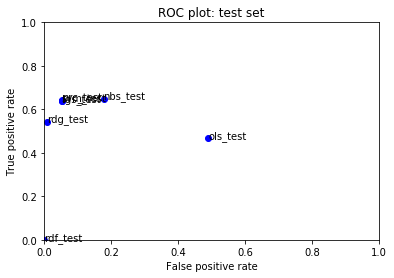

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48607375101198713


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation